# CS105 Fall 2025 Team 7 Mini Project Report
## Author: Lydia Niu, Ryan Kim, Jonathan Chun, Stuart Arief, Colin Pham

# Topic Presentation
### - Stuart Arief: 
### - Ryan Kim:
### - Colin Pham:
### - Jonathan Chun:
### - Lydia Niu:


# Data
### - Mental Health rating (1-5) (numerical data)
### - Commute distance to campus in miles (numerical data)
### - Average Caffeine consumption, mg per day (continuous numerical)
### - Campus food meal consumption rate, times per week (discrete numerical)
### - Favorite cuisine rating in a scale 1-5 (discrete numerical rating)
### - Imposter syndrome rating 1-5 (discrete numerical rating)
### - Ethnicity survey (Categorical data)


# Introduction:


In [48]:
# import all the libraries and read the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from scipy.stats import chi2_contingency, chi2
from IPython.display import display, Markdown, HTML

df = pd.read_csv("responses.csv")

# EDA 1 - Mental Health Level vs Commuting Distance (Scatterplot, Stuart)

Detected columns:
- Mental health: Rate your overall mental health. 
- Commute distance: How far is your commute to UCR (in miles)? Answer with a number only.


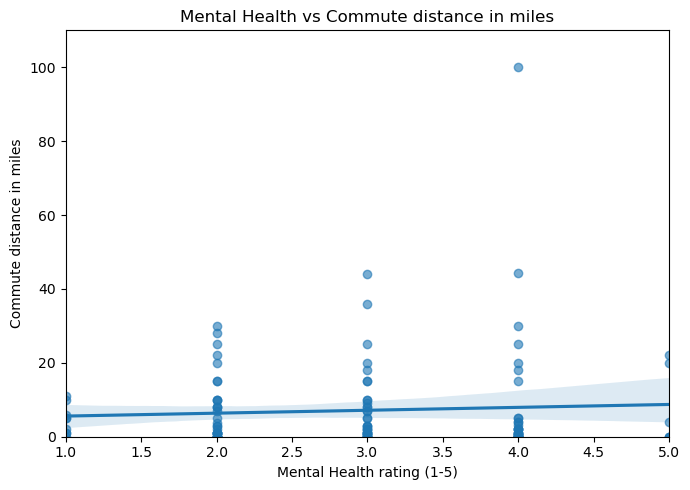

In [33]:
responses_df = pd.read_csv("responses.csv")

# ---- Normalize headers (remove newlines / smart quotes) ----
responses_df.columns = [
    re.sub(r"\s+", " ", c.replace("“", '"').replace("”", '"').replace("’", "'")).strip()
    for c in responses_df.columns
]

# ---- Detect columns ----
# mental health column (e.g., "Rate your overall mental health.")
mental_col = [c for c in responses_df.columns if ("overall" in c.lower() and "mental" in c.lower())]
if not mental_col:
    raise KeyError("Could not find the 'overall mental health' question header.")
mental_col = mental_col[0]

# Commute distance column (allowing for slight variations of 'following')
commute_col = [
    c for c in responses_df.columns
    if ("far" in c.lower() and "commute" in c.lower() and "in miles" in c.lower())
]
if not commute_col:
    raise KeyError("Could not find the 'Commute distance (…)' activity frequency header.")
commute_col = commute_col[0]

# commute_col = [
#     c for c in responses_df.columns
#     if ("how" in c.lower() and "units" in c.lower() and "this quarter" in c.lower())
# ]
# if not commute_col:
#     raise KeyError("Could not find the 'Commute distance (…)' activity frequency header.")
# commute_col = commute_col[0]

# Commute distance column (allowing for slight variations of 'following')

print("Detected columns:\n- Mental health:", mental_col, "\n- Commute distance:", commute_col)

# ---- Clean values to numeric ----
def extract_full_number(x):
    """Extract the first full number (integer or float) from mixed responses; else NaN."""
    if pd.isna(x):
        return np.nan
    
    s = str(x).strip()
    # Regex to find the first floating-point number pattern in the string
    match = re.search(r'^-?\d*\.?\d+(?:[eE][+-]?\d+)?', s)
    
    if match:
        number_str = match.group(0)
        try:
            return float(number_str)
        except ValueError:
            return np.nan
    else:
        return np.nan

responses_df["mental_health"] = responses_df[mental_col].apply(extract_full_number)
responses_df["commute_distance"] = responses_df[commute_col].apply(extract_full_number)

# ---- Drop rows with missing values for this plot ----
plot_df = responses_df.dropna(subset=["mental_health", "commute_distance"])

# ---- Create scatter + regression line ----
plt.figure(figsize=(7, 5))
sns.regplot(
    data=plot_df,
    x="mental_health",
    y="commute_distance",
    scatter_kws={"alpha": 0.6}
)

# ---- Titles and labels ----
plt.title("Mental Health vs Commute distance in miles")
plt.xlabel("Mental Health rating (1-5)")
plt.ylabel("Commute distance in miles")

# ---- Nice bounds (Like on x is usually 1–5) ----
plt.xlim(1,5)
plt.ylim(bottom = 0, top = 110)

plt.tight_layout()
plt.show()

## Introduction: 


## Analysis: 

# EDA2 - Mental Health vs Imposter Syndrome Rating (Violin, Lydia)

/var/folders/_2/3lrnsn7x5615sf09xw7cfcfm0000gn/T/ipykernel_82385/1821042047.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


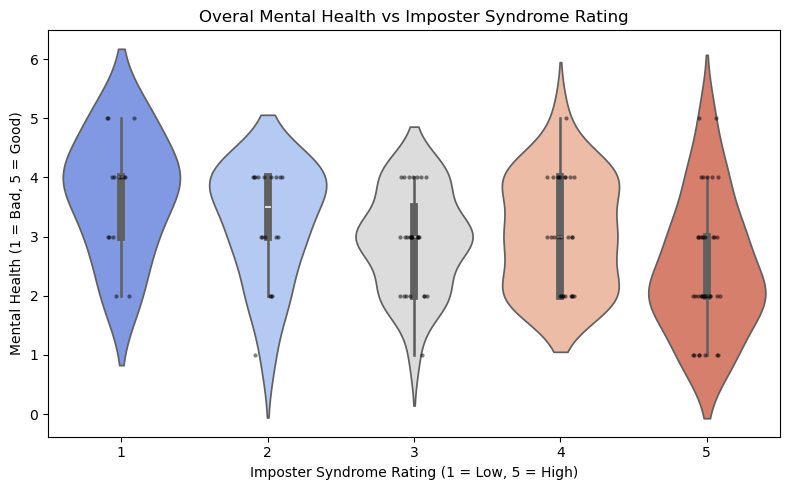

In [34]:
is_col = 'The National Library of Medicine defines imposter syndrome as, " a behavioral health phenomenon described as self-doubt of intellect, skills, or accomplishments among high-achieving individuals" ("Imposter Phenomenon", 2023). Based on this definition please rate your level of imposter syndrome through your journey in your major. '
seat_col = 'From the front of the class (ranked 1) to the back of the class (ranked 5), where do you sit on average for lecture?'
mental_health_col = 'Rate your overall mental health.'
caff_col = 'How many milligrams of caffeine do you consume per day, on average? For example, a cup of coffee is 95 mg, a shot of espresso is 64mg, a can of Celsius is 200 mg, and a  can of Coca Cola is 34 mg. Answer with a number only.'
is_order = ['1', '2', '3', '4', '5']

# Select relevant columns and drop missing values
df_plot = df[[is_col, mental_health_col]].dropna()

# Convert IS to integer (if stored as float)
df_plot[is_col] = df_plot[is_col].astype(int)

# Violin plot — one violin per IS rating (1–5)
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x=is_col,
    y=mental_health_col,
    palette="coolwarm",
    inner="box"
)
sns.stripplot(
    data=df_plot,
    x=is_col,
    y=mental_health_col,
    color='k',
    alpha=0.5,
    jitter=True,
    size=3
)
plt.title("Overal Mental Health vs Imposter Syndrome Rating")
plt.xlabel("Imposter Syndrome Rating (1 = Low, 5 = High)")
plt.ylabel("Mental Health (1 = Bad, 5 = Good)") # need the scale info, 1=bad or good?
plt.tight_layout()
plt.show()



## Introduction: 


## Analysis: 

# EDA3 - Caffeine Consumption vs Imposter Syndrome Rating (Violin, Lydia)

/var/folders/_2/3lrnsn7x5615sf09xw7cfcfm0000gn/T/ipykernel_82385/1074205603.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


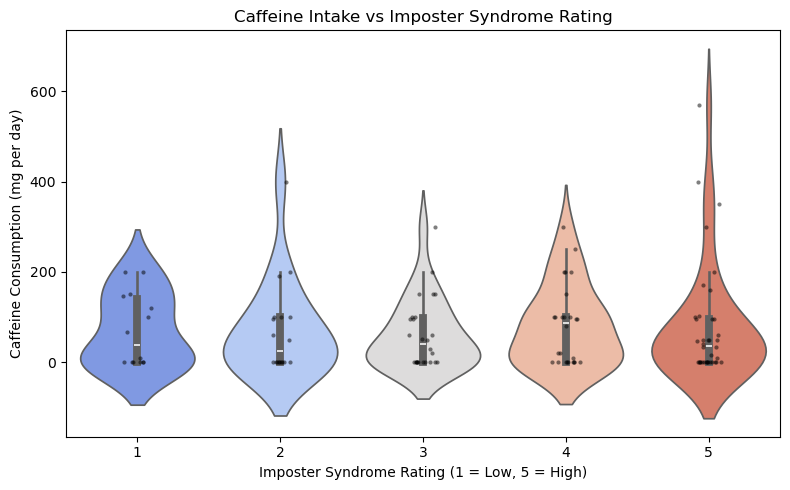

In [35]:
caff_col_clean = 'caffeine_mg'  # new numeric column

# Clean the caffeine data
# Copy column and strip spaces
caff = df[caff_col].astype(str).str.strip().copy()


# Cleaning function
def clean_caffeine(x):
    if pd.isna(x) or x.lower() in ['n/a', 'na']:
        return np.nan
    # Case 1: contains 'mg'
    if 'mg' in x.lower():
        try:
            return float(x.lower().replace('mg','').strip())
        except:
            return np.nan
    # Case 2: range like "95-300"
    if '-' in x:
        try:
            parts = x.split('-')
            nums = [float(p.strip()) for p in parts]
            return np.mean(nums)  # take the average of the range
        except:
            return np.nan
    # Case 3: just a number
    try:
        return float(x)
    except:
        return np.nan

# Apply cleaning
df[caff_col_clean] = caff.apply(clean_caffeine)

# Optional: inspect cleaned data
# print(df[caff_col_clean].describe())
# print(np.sort(df[caff_col_clean].dropna().unique()))

# ------------------------------
# Prepare data for plotting
# ------------------------------
df_plot = df[[is_col, caff_col_clean]].dropna().copy()
df_plot[is_col] = df_plot[is_col].astype(int).astype(str)  # treat IS rating as categorical

# ------------------------------
# Create violin plot
# ------------------------------
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x=is_col,
    y=caff_col_clean,
    palette="coolwarm",
    inner="box",
    order=is_order 
)

# Optional: add individual participant points
sns.stripplot(
    data=df_plot,
    x=is_col,
    y=caff_col_clean,
    color='k',
    alpha=0.5,
    jitter=True,
    size=3
)

# Labels and title
plt.title("Caffeine Intake vs Imposter Syndrome Rating")
plt.xlabel("Imposter Syndrome Rating (1 = Low, 5 = High)")
plt.ylabel("Caffeine Consumption (mg per day)")
plt.tight_layout()
plt.show()



## Introduction: 


## Analysis: 

# EDA4 - Caffeine consumption vs Campus Meal Consumption (Scatterplot, Ryan)

/var/folders/_2/3lrnsn7x5615sf09xw7cfcfm0000gn/T/ipykernel_82385/2191714426.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


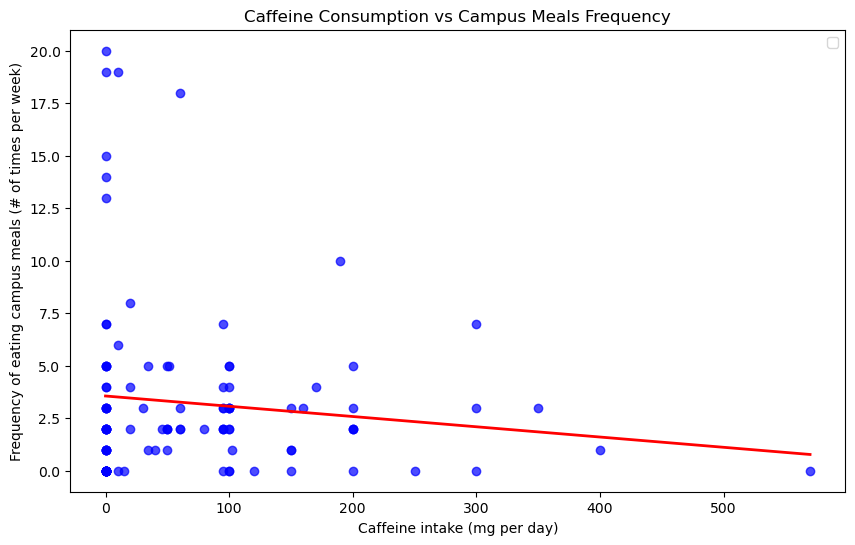

In [36]:
Caffeine_mg  = [col for col in df.columns if "caffeine" in col.lower()]
Campus_Meals = [col for col in df.columns if "substantial" in col.lower()]
Diet_Rating  = [col for col in df.columns if "diet" in col.lower()]

if Caffeine_mg:  df.rename(columns={Caffeine_mg[0]: 'Caffeine_mg'}, inplace=True)
if Campus_Meals: df.rename(columns={Campus_Meals[0]: 'Campus_Meals'}, inplace=True)
if Diet_Rating:  df.rename(columns={Diet_Rating[0]: 'Diet_Rating'}, inplace=True)

for col in ['Caffeine_mg', 'Campus_Meals', 'Diet_Rating']: df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['Caffeine_mg', 'Campus_Meals', 'Diet_Rating'])

# Scatter plot graphing
plt.figure(figsize=(10,6))
plt.scatter(df['Caffeine_mg'], df['Campus_Meals'], alpha=0.7, color='blue')

# Linear regression line -- shows that there is negative correlation between the two.
slope, intercept = np.polyfit(df['Caffeine_mg'], df['Campus_Meals'], 1)
x_vals = np.array([df['Caffeine_mg'].min(), df['Caffeine_mg'].max()])
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', linewidth=2)

plt.xlabel("Caffeine intake (mg per day)")
plt.ylabel("Frequency of eating campus meals (# of times per week)")
plt.title("Caffeine Consumption vs Campus Meals Frequency")
plt.legend()
plt.show()

## Introduction: 


## Analysis: 

# EDA5 - CS vs DS Student Health Habits (Parallel Coordinate, Colin)

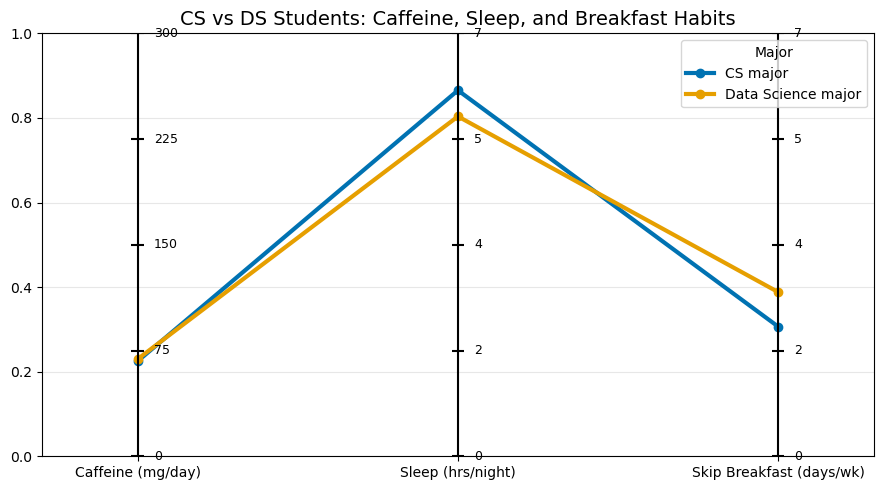

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

df = pd.read_csv("responses.csv")
col_major = 'What is your major/minor? (If your major is not listed, please write it in "Other..")'
col_caff  = 'How many milligrams of caffeine do you consume per day, on average? For example, a cup of coffee is 95 mg, a shot of espresso is 64mg, a can of Celsius is 200 mg, and a  can of Coca Cola is 34 mg. Answer with a number only.'
col_sleep = 'Fill in the following table over how often you did each activity for in the past week. [Sleep per night (average hours)]'
col_skip  = 'How many days per week do you skip breakfast?'

df_sub = df[[col_major, col_caff, col_sleep, col_skip]].copy()
df_sub.columns = ['Major', 'Caffeine', 'Sleep', 'Skip']
df_sub = df_sub[df_sub['Major'].isin(['CS major', 'Data Science major'])]

def to_mid(val):
    if pd.isna(val):
        return np.nan
    nums = [float(x) for x in re.findall(r'\d+\.?\d*', str(val))]
    if len(nums) == 1:
        return nums[0]
    elif len(nums) >= 2:
        return np.mean(nums[:2])
    return np.nan

df_sub['Caffeine'] = pd.to_numeric(df_sub['Caffeine'], errors='coerce').clip(0, 300)
df_sub['Sleep'] = df_sub['Sleep'].apply(to_mid).clip(0, 7)
df_sub['Skip'] = df_sub['Skip'].apply(to_mid).clip(0, 7)

df_sub = df_sub.dropna(subset=['Caffeine', 'Sleep', 'Skip'])
avg = df_sub.groupby('Major')[['Caffeine', 'Sleep', 'Skip']].mean().reset_index()
fig, ax = plt.subplots(figsize=(9, 5))

x_pos = [0, 1, 2]
variables = ['Caffeine', 'Sleep', 'Skip']
scales = [(0, 300), (0, 7), (0, 7)]
colors = {'CS major': '#0072B2', 'Data Science major': '#E69F00'}

for major in avg['Major']:
    y_scaled = []
    for (var, (low, high)) in zip(variables, scales):
        val = avg.loc[avg['Major'] == major, var].values[0]
        scaled = (val - low) / (high - low)
        y_scaled.append(scaled)
    plt.plot(x_pos, y_scaled, marker='o', linewidth=3, label=major, color=colors[major])
plt.xticks(x_pos, ['Caffeine (mg/day)', 'Sleep (hrs/night)', 'Skip Breakfast (days/wk)'])
plt.title("CS vs DS Students: Caffeine, Sleep, and Breakfast Habits", fontsize=14)
plt.legend(title="Major")
for i, (low, high) in enumerate(scales):
    plt.vlines(x_pos[i], 0, 1, color='black')
    ticks = np.linspace(0, 1, 5)
    values = np.linspace(low, high, 5)
    for t, v in zip(ticks, values):
        plt.hlines(t, x_pos[i] - 0.02, x_pos[i] + 0.02, color='black')
        plt.text(x_pos[i] + 0.05, t, f"{v:.0f}", va='center', fontsize=9)

plt.xlim(-0.3, 2.3)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Introduction: 


## Analysis: 

# EDA6 - Amount of times skipping breakfast vs. On-Campus eating (Stacked bar, Colin)

<function matplotlib.pyplot.show(close=None, block=None)>

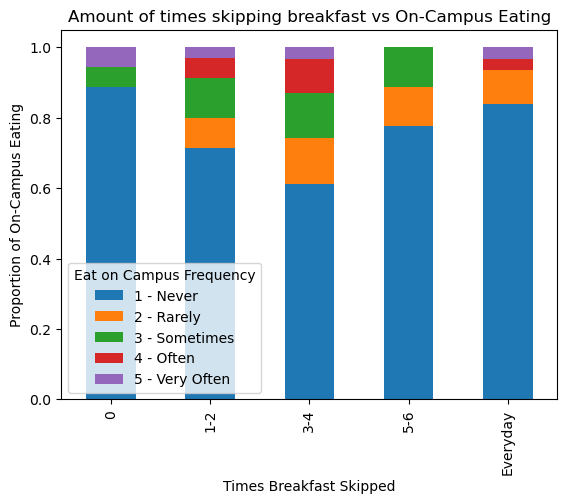

In [38]:
table2 = pd.crosstab(df["How many days per week do you skip breakfast?"], df["Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Dining hall (Glasgow and Lothian)]"], normalize="index")

table2.plot(kind="bar", stacked=True)
plt.title("Amount of times skipping breakfast vs On-Campus Eating")
plt.ylabel("Proportion of On-Campus Eating")
plt.xlabel("Times Breakfast Skipped")
plt.legend(title="Eat on Campus Frequency")
plt.show

## Introduction: 


## Analysis: 

# EDA7 - Campus Food Option Frequency (Spider, Jonathan)

Meal columns detected: 9
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Subway]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Habit Burger]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Panda Express]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Chronic Tacos]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Hibachi-san]
 - Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often). [Halal Shack]
 - Please rate how often you eat at each of the following

/var/folders/_2/3lrnsn7x5615sf09xw7cfcfm0000gn/T/ipykernel_82385/2367298109.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  meal_data = df[meal_cols].applymap(clean_rating)


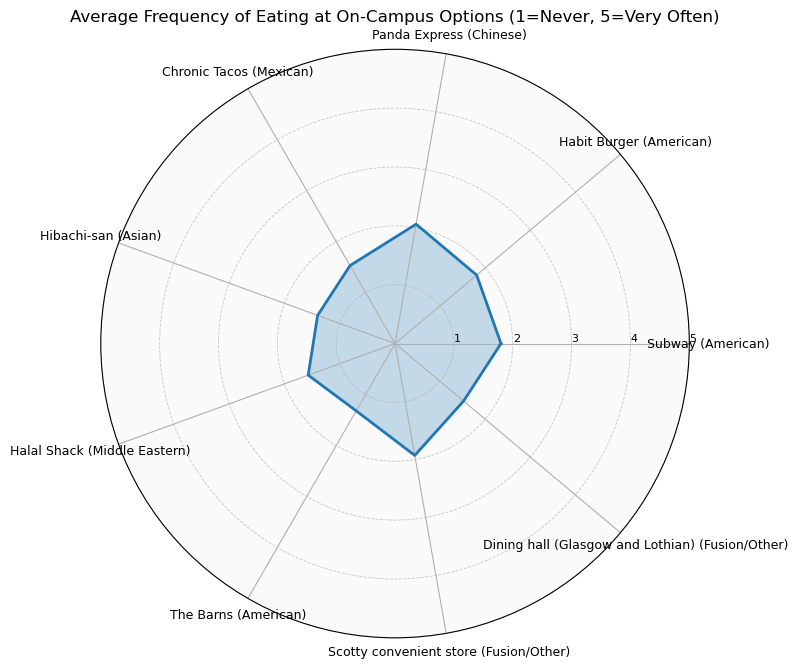

In [39]:
# ---- Define restaurant-cuisine mapping ----
# You can replace this with actual restaurant names and cuisine types
restaurant_cuisines = {
    "The Barns": "American",
    "Subway": "American",
    "Panda Express": "Chinese",
    "Habit Burger": "American",
    "Hibachi-san": "Asian",
    "Chronic Tacos": "Mexican",
    "Dining hall (Glasgow and Lothian)" : "Fusion/Other",
    "Scotty convenient store" : "Fusion/Other",
    "Halal Shack" : "Middle Eastern"
    # Add more restaurants and their cuisines here
}

# ---- Select columns: on-campus meal frequency ----
meal_cols = [
    col for col in df.columns
    if "Please rate how often you eat at each of the following on-campus meal options" in col
]

print(f"Meal columns detected: {len(meal_cols)}")
for c in meal_cols:
    print(" -", c)

# ---- Clean ratings to integers 1–5 ----
def clean_rating(x):
    """
    Converts Google Form mixed strings like '5', '5.0', '5 - Very Often'
    to int 1–5; returns NaN if not parseable.
    """
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    for ch in x:
        if ch.isdigit():
            return int(ch)
    return np.nan

meal_data = df[meal_cols].applymap(clean_rating)

# ---- Compute averages (per restaurant) ----
avg_ratings = meal_data.mean().round(2)

# ---- Pretty labels (inside square brackets) with cuisine types ----
labels = [f"{col.split('[')[-1].split(']')[0]} ({restaurant_cuisines.get(col.split('[')[-1].split(']')[0], 'Unknown')})" for col in meal_cols]

# ---- Radar prep ----
values = avg_ratings.values.tolist()
values += values[:1]  # close loop

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# ---- Plot (Radar) ----
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values, linewidth=2, linestyle="solid", color="#1f77b4")
ax.fill(angles, values, alpha=0.25, color="#1f77b4")

# ---- Axis labels ----
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=9)

# ---- Set explicit floor/ceiling and tick marks ----
ax.set_ylim(0, 3)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(["1", "2", "3", "4", "5"], fontsize=8)
ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

# ---- Optional: emphasize visual spacing for ratings ----
ax.set_rlabel_position(0)
ax.set_facecolor("#fafafa")

plt.title("Average Frequency of Eating at On-Campus Options (1=Never, 5=Very Often)", pad=20)
plt.tight_layout()
plt.show()

## Introduction: 


## Analysis: 

# EDA8 - Region of Favorite Cuisine vs On-Campus Restaurant Choice (Heat map, Lydia)

In [40]:
fav_cuisine = df[[c for c in df.columns if "Please rank the following cuisines by your preference. (1 being dislike, 5 being like)" in c]]
fav_cuisine.columns = fav_cuisine.columns.str.extract(r'\[(.*)\]')[0]
# print(fav_cuisine.columns.tolist())

# convert to numeric
fav_cuisine = fav_cuisine.apply(lambda col: col.astype(str).str.split(' - ').str[0])
fav_cuisine = fav_cuisine.apply(pd.to_numeric, errors='coerce')
# fav_cuisine

# extract restaurant rating columns
rest_rating_cols = df[[c for c in df.columns if "Please rate how often you eat at each of the following on-campus meal options on a scale of 1 to 5 (1 being Never, 5 being Very Often)." in c]]
rest_rating_cols.columns = rest_rating_cols.columns.str.extract(r'\[(.*)\]')[0]
# print(rest_rating_cols.columns.tolist()) # test print

# convert to numeric
rest_rating_cols = rest_rating_cols.apply(lambda col: col.astype(str).str.split(' - ').str[0])
rest_rating_cols = rest_rating_cols.apply(pd.to_numeric, errors='coerce')
# rest_rating_cols.head() # test print

# find other cuisine and rating pairs
df3 = df[["Please rank the following cuisines by your preference. (1 being dislike, 5 being like) [Other Cuisine (please specify in the next question)]", "Please list any other cuisines not included."]]
df3 = df3.rename(columns={
   "Please rank the following cuisines by your preference. (1 being dislike, 5 being like) [Other Cuisine (please specify in the next question)]": "other_cuisine_rate",
    "Please list any other cuisines not included.": "cuisine_name"
})
# print(df3["cuisine_name"].unique())

# clean the data
df3_cleaned = df3.replace(['nan','0','NA', 'na', 'Na', 'N/A','N/a',"Couldn't think of any", "n/A", "no","none",
                           "Not sure","I don't know any others", "N/a",'the rest was uncluded','None ', 'No','idk',
                           '̸̧̛̺̹̟̮͇͖̺̹͇͉̪̹͇͇̈́́̒̋͌̄̑̊̍̔͘͝ͅͅ¿̷̨̯̖̯͙̳̙̖̹̱̤͎̱̤̳́͛̈́̈́̈́̒̉͊͛̕͘̚̕͜','I dont know any other not listed','-','Snacks',"Pizza",'chipotle','convenience foods',
                           'Anything','Soul Food'], pd.NA).dropna()
# print(df3_cleaned["cuisine_name"].unique())

# convert to numeric
df3_cleaned['other_cuisine_rate'] = (df3_cleaned['other_cuisine_rate'].astype(str).str.split(' - ').str[0])
df3_cleaned['other_cuisine_rate'] = pd.to_numeric(df3_cleaned['other_cuisine_rate'], errors='coerce')
# df3_cleaned

# Print column names of the full dataset and the combined cuisine dataframe
# print(f"\ndf3_whole columns ({len(df3_whole.columns)}):")
# print(df3_whole.columns.tolist())

# assign the cuisine columns to region groups
cuisine_region_map = {
    'Chinese food': 'Asian', 
    'Japanese food': 'Asian',
    'Korean food': 'Asian',
    'Indian food': 'Asian',
    'Vietnamese food': 'Asian',
    'Thai': 'Asian',
    'Thai food': 'Asian',
    'tai food': 'Asian',
    'Filipino': 'Asian',
    'Filipino food': 'Asian',
    'filipino': 'Asian',
    'Indonesian food': 'Asian',
    'Malaysian Food': 'Asian',
    'Mongolian': 'Asian',
    'Pakistani Food': 'Asian',
    'Sri Lankan': 'Asian',
    'Taiwanese food': 'Asian',
    
    'Italian food': 'European',
    'French food': 'European',
    'Spanish Food': 'European',
    'Eastern European': 'European',
    'Russian and Eastern European dishes': 'European',
    
    'Mexican food': 'Latin American',
    'Salvadorean': 'Latin American', 
    
    'American food': 'North American',
    
    'Mediterranean food': 'Middle Eastern/African',
    'Middle Eastern': 'Middle Eastern/African',
    'Not sure if it counts as mediterranean, but I like food from the Middle East.': 'Middle Eastern/African',
    
    'African Food': 'Middle Eastern/African',
    'Ethiopian': 'Middle Eastern/African',
    'Nigerian, west African ': 'Middle Eastern/African',
    'South African': 'Middle Eastern/African',
    
    'Fusion / Modern mix cuisine': 'Fusion/Other'
}

restaurant_region_map = {
    'Subway': 'European',
    'Habit Burger': 'North American',
    'Panda Express': 'Asian',
    'Chronic Tacos': 'Latin American',
    'Hibachi-san': 'Asian',
    'Halal Shack': 'Middle Eastern/African',
    'The Barns': 'North American',
    'Scotty convenient store': 'North American',
    'Dining hall (Glasgow and Lothian)': 'Fusion/Other'
}

In [41]:
# Clean column names (for consistency)
fav_cuisine.columns = fav_cuisine.columns.str.strip().str.lower()
rest_rating_cols.columns = rest_rating_cols.columns.str.strip().str.lower()

# Normalize mapping keys
cuisine_region_map = {k.lower().strip(): v for k, v in cuisine_region_map.items()}
restaurant_region_map = {k.lower().strip(): v for k, v in restaurant_region_map.items()}

# Group cuisines by region
fav_cuisine_by_region = pd.DataFrame(index=fav_cuisine.index)

for region in sorted(set(cuisine_region_map.values())):
    # find all cuisine columns belonging to this region that exist in dataframe
    region_cols = [c for c, r in cuisine_region_map.items() if r == region and c in fav_cuisine.columns]
    if region_cols:
        # calculate mean rating across those cuisines for each participant
        fav_cuisine_by_region[region] = fav_cuisine[region_cols].mean(axis=1, skipna=True)
    else:
        # if no columns found, fill with NaN (keeps row count intact)
        fav_cuisine_by_region[region] = pd.NA

# Group restaurants by region
rest_rating_by_region = pd.DataFrame(index=rest_rating_cols.index)

for region in sorted(set(restaurant_region_map.values())):
    region_cols = [r for r, reg in restaurant_region_map.items() if reg == region and r in rest_rating_cols.columns]
    if region_cols:
        rest_rating_by_region[region] = rest_rating_cols[region_cols].mean(axis=1, skipna=True)
    else:
        rest_rating_by_region[region] = pd.NA


# Make sure the two dataframes share the same participants
common_index = fav_cuisine_by_region.index.intersection(rest_rating_by_region.index)
fav_cuisine_by_region = fav_cuisine_by_region.loc[common_index]
rest_rating_by_region = rest_rating_by_region.loc[common_index]

# Normalize per participant (row-wise z-score)
def row_zscore(df):
    """Normalize each participant’s ratings (row) by their mean and std."""
    return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

fav_norm = row_zscore(fav_cuisine_by_region)
rest_norm = row_zscore(rest_rating_by_region)

# Compute heatmap data
heatmap_data = pd.DataFrame(
    index=fav_norm.columns,
    columns=rest_norm.columns,
    data=[
        [
            np.mean(fav_norm[cuisine]) + np.mean(rest_norm[restaurant])
            for restaurant in rest_norm.columns
        ]
        for cuisine in fav_norm.columns
    ]
)

# Normalize to mean-centered scale for better contrast
heatmap_data = heatmap_data - heatmap_data.mean().mean()

region_order = [
    "Asian",
    "European",
    "North American",
    "Latin American",
    "Middle Eastern/African",
    "Fusion/Other"
]
heatmap_ordered = heatmap_data.loc[
    [r for r in region_order if r in heatmap_data.index],
    [c for c in region_order if c in heatmap_data.columns]
]


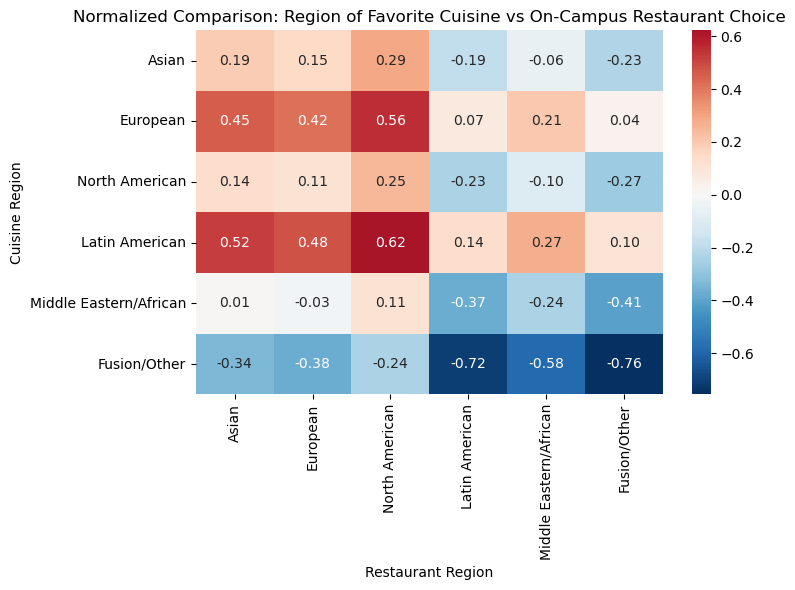

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_ordered, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
plt.title("Normalized Comparison: Region of Favorite Cuisine vs On-Campus Restaurant Choice")
plt.xlabel("Restaurant Region")
plt.ylabel("Cuisine Region")
plt.tight_layout()
plt.show()

## Introduction: 


## Analysis: 

# EDA9 - Cuisine Preference based on Ethnic Background (Stacked bar, Jonathan)

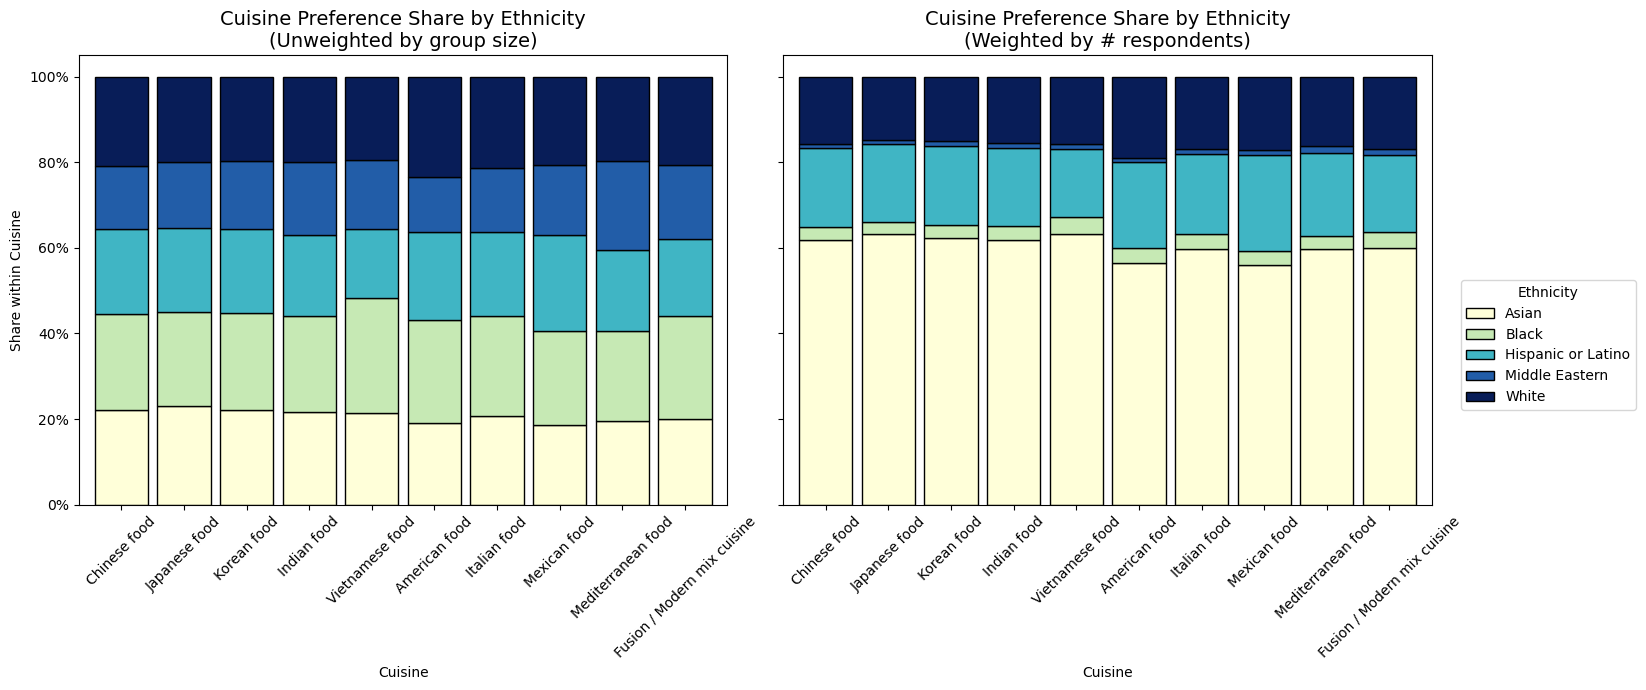

Respondent counts by ethnicity (after explode):
Ethnicity
Asian                 81
Black                  4
Hispanic or Latino    27
Middle Eastern         2
White                 22
dtype: int64


In [43]:
def _norm(s: str) -> str:
    s = str(s)
    s = s.replace("\r"," ").replace("\n"," ")
    s = s.replace("“",'"').replace("”",'"').replace("’","'")
    s = re.sub(r"\s+"," ", s).strip()
    return s

df.columns = [_norm(c) for c in df.columns]

# ---------- Detect columns ----------
eth_cols = [c for c in df.columns if "ethnic" in c.lower()]
assert eth_cols, "Could not find an ethnicity column (searching for 'ethnic')."
eth_col = eth_cols[0]

cuisine_cols = [c for c in df.columns
                if "please rank the following cuisines by your preference" in c.lower()]
assert cuisine_cols, "No cuisine preference columns found."

# ---------- Clean Likert to 1–5 ----------
def clean_rating(x):
    if pd.isna(x): return np.nan
    for ch in str(x).strip():
        if ch.isdigit():
            return int(ch)
    return np.nan

for c in cuisine_cols:
    df[c] = df[c].apply(clean_rating)

# ---------- Simplified ethnicity (explode multi-select) ----------
ETH_PATTERN = {
    "Asian": re.compile(r"\basian\b|\bchinese\b|\bkorean\b|\bjapanese\b|\bfilipin[oa]\b|\bindian\b|\bviet", re.I),
    "Black": re.compile(r"\bblack\b|\bafrican\s*american\b|\bafrican\b", re.I),
    "Hispanic or Latino": re.compile(r"\bhispanic\b|\blatin[oa]\b|\blatinx\b|\blatine\b", re.I),
    "Middle Eastern": re.compile(r"\bmiddle[-\s]*eastern\b|\bmena\b|\barab(ic)?\b|\biranian\b|\bpersian\b|\bturk(ish)?\b|\bkurd(ish)?\b", re.I),
    "White": re.compile(r"\bwhite\b|\bcaucasian\b|\beuropean\b", re.I),
}
keep_order = ["Asian","Black","Hispanic or Latino","Middle Eastern","White"]

def split_ethnicities(val):
    if pd.isna(val): return []
    s = _norm(val).lower()
    parts = re.split(r"[;,/]| and | & ", s)
    found = set()
    for p in parts:
        for label, rx in ETH_PATTERN.items():
            if rx.search(p):
                found.add(label)
    return sorted(found)

tmp = df[[eth_col] + cuisine_cols].copy()
tmp["Ethnicity"] = tmp[eth_col].apply(split_ethnicities)
tmp = tmp.explode("Ethnicity", ignore_index=True)
tmp = tmp[tmp["Ethnicity"].isin(keep_order)]

# ---------- Compute: means (unweighted), sums (weighted by n), counts ----------
means = tmp.groupby("Ethnicity")[cuisine_cols].mean().reindex(keep_order)
sums  = tmp.groupby("Ethnicity")[cuisine_cols].sum().reindex(keep_order)
counts = tmp.groupby("Ethnicity")[cuisine_cols].count().reindex(keep_order).fillna(0).astype(int)

# ---------- Pretty cuisine labels ----------
pretty = {c: (c.split('[')[-1].split(']')[0] if '[' in c and ']' in c else c) for c in cuisine_cols}
means = means.rename(columns=pretty)
sums  = sums.rename(columns=pretty)

# ---------- Remove "Other Cuisine" ----------
to_drop = [c for c in means.columns if "other cuisine" in c.lower()]
if to_drop:
    means = means.drop(columns=to_drop)
    sums = sums.drop(columns=to_drop)

# ---------- Convert to 100% stacked shares ----------
unweighted_share = means.divide(means.sum(axis=0), axis=1)
weighted_share = sums.divide(sums.sum(axis=0), axis=1)

# ---------- Plot side-by-side (clean shared legend) ----------
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Unweighted
unweighted_share.T.plot(
    kind="bar", stacked=True, ax=axes[0],
    width=0.85, edgecolor="black", cmap="YlGnBu", legend=False
)
axes[0].set_title("Cuisine Preference Share by Ethnicity\n(Unweighted by group size)", fontsize=14)
axes[0].set_xlabel("Cuisine"); axes[0].set_ylabel("Share within Cuisine")
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f"{int(y*100)}%"))
axes[0].tick_params(axis='x', rotation=45)

# Weighted
weighted_share.T.plot(
    kind="bar", stacked=True, ax=axes[1],
    width=0.85, edgecolor="black", cmap="YlGnBu", legend=False
)
axes[1].set_title("Cuisine Preference Share by Ethnicity\n(Weighted by # respondents)", fontsize=14)
axes[1].set_xlabel("Cuisine"); axes[1].set_ylabel("")
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f"{int(y*100)}%"))
axes[1].tick_params(axis='x', rotation=45)

# ---------- Single shared legend ----------
handles, labels = axes[1].get_legend_handles_labels()
if not handles:  # fallback if pandas version changes handle retrieval
    handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels, title="Ethnicity", loc="center right",
           bbox_to_anchor=(1.03, 0.5), fontsize=10)

plt.tight_layout(rect=[0,0,0.93,1])
plt.show()

# ---------- Optional: print respondent counts ----------
print("Respondent counts by ethnicity (after explode):")
print(counts.max(axis=1).reindex(keep_order))


### Introduction: 


### Analysis: 

# Hypothesis

### EDA1 - Mental Health Level vs Commuting Distance:

The initial hypothesis for the Mental Health Level vs. Commuting distance visualization (3.1) was a linear negative correlation. That is, the less time a student spends commuting, the higher their mental health level would be.

### EDA4 - Caffeine Consumption vs Campus Meal Consumption:
The initial hypothesis for the relationship between caffeine and campus food consumption (EDA 4) was a positive linear correlation. It was predicted that the more caffeine a student consumed, the more likely they were to also buy food on campus. 

### EDA9 - Cuisine Preference based on Ethnic Background:

# Statistical Tests:


### EDA1 - Mental Health Level vs Commuting Distance: 

From the google spreadsheet below, we can infer that the hypothesis is not true. With a Chi-square value of 16.874, and a DF of 16, we get a P-value of 0.39375. 
This insignificance shows that there is no correlation between the two variables.


Link to the Chi-Square test: https://docs.google.com/spreadsheets/d/17tkJw5mBfaPDacd1wRBbFCCSg-2OcoROHf2IEuV_2JE/edit?gid=0#gid=0

### EDA4: Caffeine Consumption vs Campus Food Consumption

From the Pearson Correlation, there is a negative correlation between the two variables at Rxy = -0.1193. 

The coefficient is weak, but the two variables are inversely related. Therefore, the initial hypothesis was incorrect.

Link to the Pearson Correlation Test result: https://docs.google.com/spreadsheets/d/1Z9t87CgnTzITcG6xMT48wEhlaXgj9TliHoIDhvVV42w/edit?usp=sharing

### EDA9 - Cuisine Preference based on Ethnic Background:

In [45]:
alpha = 0.05  # set your significance level (e.g., 0.05, 0.01, 0.001)

# Use the original cuisine columns but drop the "Other Cuisine..." one (to match your plots)
filtered_cuisine_cols = []
for c in cuisine_cols:
    pretty_name = pretty.get(c, c)
    if "other cuisine" not in str(pretty_name).lower():
        filtered_cuisine_cols.append(c)

chi_results = []  # (pretty_name, chi2, dof, p, N, critical, decision)

print("\n--- Chi-Square Test of Independence: Ethnicity × Cuisine Preference ---\n")
for c in filtered_cuisine_cols:
    pretty_name = pretty.get(c, c)

    # Contingency table: rows = Ethnicity (in keep_order), cols = rating 1..5
    ct = pd.crosstab(tmp["Ethnicity"], df[c])  # df[c] already cleaned to 1–5 in your code

    # Reindex rows to consistent ethnicity order; keep only rating columns present
    ct = ct.reindex(index=keep_order).dropna(how="all")
    if ct.shape[0] < 2 or ct.shape[1] < 2:
        # Not enough data to test
        print(f"{pretty_name}: skipped (insufficient data)")
        continue

    chi_stat, p_val, dof, expected = chi2_contingency(ct)
    critical = chi2.ppf(1 - alpha, dof)
    decision = "Reject H₀" if chi_stat > critical else "Fail to Reject H₀"

    chi_results.append((pretty_name, chi_stat, dof, p_val, int(ct.to_numpy().sum()), critical, decision))

    print(f"{pretty_name}:")
    print(f"  χ² = {chi_stat:.2f},  df = {dof},  critical@α={alpha} → {critical:.2f},  p = {p_val:.4f}")
    print(f"  → {decision} — ethnicity and rating are "
          f"{'associated' if decision=='Reject H₀' else 'not significantly associated'}.\n")

# Summary table sorted by p-value
chi_df = pd.DataFrame(chi_results, columns=["Cuisine", "Chi2", "df", "p_value", "N", "Critical", "Decision"])
display(chi_df.sort_values("p_value").reset_index(drop=True))


--- Chi-Square Test of Independence: Ethnicity × Cuisine Preference ---

Chinese food:
  χ² = 12.00,  df = 16,  critical@α=0.05 → 26.30,  p = 0.7442
  → Fail to Reject H₀ — ethnicity and rating are not significantly associated.

Japanese food:
  χ² = 6.37,  df = 16,  critical@α=0.05 → 26.30,  p = 0.9835
  → Fail to Reject H₀ — ethnicity and rating are not significantly associated.

Korean food:
  χ² = 11.08,  df = 16,  critical@α=0.05 → 26.30,  p = 0.8045
  → Fail to Reject H₀ — ethnicity and rating are not significantly associated.

Indian food:
  χ² = 7.29,  df = 16,  critical@α=0.05 → 26.30,  p = 0.9673
  → Fail to Reject H₀ — ethnicity and rating are not significantly associated.

Vietnamese food:
  χ² = 10.45,  df = 16,  critical@α=0.05 → 26.30,  p = 0.8421
  → Fail to Reject H₀ — ethnicity and rating are not significantly associated.

American food:
  χ² = 14.35,  df = 16,  critical@α=0.05 → 26.30,  p = 0.5729
  → Fail to Reject H₀ — ethnicity and rating are not significantly as

,Cuisine,Chi2,df,p_value,N,Critical,Decision
0,Italian food,19.150907,16,0.260915,120,26.296228,Fail to Reject H₀
1,Fusion / Modern mix cuisine,16.468846,16,0.420745,120,26.296228,Fail to Reject H₀
2,Mediterranean food,15.145821,16,0.513985,120,26.296228,Fail to Reject H₀
3,American food,14.347163,16,0.572868,120,26.296228,Fail to Reject H₀
4,Mexican food,12.991299,16,0.673394,120,26.296228,Fail to Reject H₀
5,Chinese food,11.997165,16,0.744175,120,26.296228,Fail to Reject H₀
6,Korean food,11.080584,16,0.804484,120,26.296228,Fail to Reject H₀
7,Vietnamese food,10.449726,16,0.842112,120,26.296228,Fail to Reject H₀
8,Indian food,7.286024,16,0.967346,120,26.296228,Fail to Reject H₀
9,Japanese food,6.373273,16,0.983539,120,26.296228,Fail to Reject H₀


# Overall Conclusion

# Group Contribusion